# Experiment 2: Choosing between shared and group-specific labels, after observing two groups

January 2025

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from memo import memo
import jax
import jax.numpy as jnp
import optax

from enum import IntEnum

import utils

pd.set_option('future.no_silent_downcasting', True)
sns.set_context('poster', font_scale=1.3)

## Model

In [6]:
class TangramTypes(IntEnum):
    shared = 0
    unique = 1


class Responses(IntEnum):
    shared = 0
    unique = 1  


class AudienceConditions(IntEnum):
    either = 0
    one = 1


class Audiences(IntEnum):
    ingroup = 1
    outgroup = 0

In [7]:
# type: ignore

@jax.jit
def audience_wpp(audience_condition, audience):
    # for the "either group" condition, return 1 regardless of audience
    # for the "one group" condition, return 1 for the ingroup and 0 for the outgroup
    return jnp.array([1, audience])[audience_condition]


@jax.jit
def ref_info(audience, utterance):
    ingroup_info = jnp.array([1, 1])  # [shared, group-specific]
    outgroup_info = jnp.array([1, 0])

    info = jax.lax.cond(
        audience == Audiences.ingroup,
        lambda _: ingroup_info,
        lambda _: outgroup_info,
        operand=None,
    )

    return info[utterance]


@jax.jit
def social_info(utterance):
    return jnp.array([0, 1])[utterance]



@memo
def speaker[
    utterance: Responses, audience: Audiences
](audience_condition: AudienceConditions, alpha, w_r, w_s):
    cast: [speaker]
    speaker: chooses(
        audience in Audiences, wpp=audience_wpp(audience_condition, audience)
    )
    speaker: chooses(
        utterance in Responses,
        wpp=exp(
            alpha
            * (
                w_r * ref_info(audience, utterance)
                + w_s * social_info(utterance)
            )
        ),
    )
    return Pr[speaker.utterance == utterance]


## Load data

In [8]:
data = pd.read_csv("../data/shared-unique/selection_trials_clean.csv")
data.replace({"response.unique": {"shared": Responses.shared, "unique": Responses.unique}}, inplace=True)
data["response.unique"] = data["response.unique"].astype(int)

data.head()

,subject_id,item_id,counterbalance,condition,audience_group,shared.tangram,unique.tangram,response.unique
0,fbe9c050-f24d-4ae5-966b-1a87180d8065,0,b,social one,red,H,L,1
1,fbe9c050-f24d-4ae5-966b-1a87180d8065,0,b,refer one,red,D,L,1
2,fbe9c050-f24d-4ae5-966b-1a87180d8065,0,b,refer one,blue,A,L,0
3,fbe9c050-f24d-4ae5-966b-1a87180d8065,0,b,refer either,red,A,B,0
4,fbe9c050-f24d-4ae5-966b-1a87180d8065,0,b,social one,red,A,L,1


Make a jax array for each condition

In [9]:
refer_either_mask = data["condition"] == "refer either"
refer_one_mask = data["condition"] == "refer one"
social_one_mask = data["condition"] == "social one"

refer_either_responses = jnp.array(data[refer_either_mask]["response.unique"].values)
refer_one_responses = jnp.array(data[refer_one_mask]["response.unique"].values)
social_one_responses = jnp.array(data[social_one_mask]["response.unique"].values)

## Predict

Define speaker functions

In [10]:
@jax.jit
def speaker_refer_either(data, w_r, w_s): 
    return speaker(
        audience_condition=AudienceConditions.either,
        alpha=1,
        w_r=w_r,
        w_s=0
    )[1, 0]

@jax.jit
def speaker_refer_one(data, w_r, w_s): 
    return speaker(
        audience_condition=AudienceConditions.one,
        alpha=1,
        w_r=w_r,
        w_s=0
    )[1, 0]

@jax.jit
def speaker_social_one(data, w_r, w_s): 
    return speaker(
        audience_condition=AudienceConditions.one,
        alpha=1,
        w_r=0,
        w_s=w_s
    )[1, 0]

speaker_refer_either_vmap = jax.vmap(speaker_refer_either, in_axes=(0, None, None))
speaker_refer_one_vmap = jax.vmap(speaker_refer_one, in_axes=(0, None, None))
speaker_social_one_vmap = jax.vmap(speaker_social_one, in_axes=(0, None, None))

Compute preds

In [11]:
@jax.jit
def predict_all(model_type, w_r, w_s): 
    # Note that the responses data isn't actually used here, it's just to get the shape of the data
    preds_refer_either = speaker_refer_either_vmap(refer_either_responses, w_r, w_s)
    preds_refer_one = speaker_refer_one_vmap(refer_one_responses, w_r, w_s)
    preds_social_one = jax.lax.cond(
        model_type == utils.ModelType.base,
        lambda _: speaker_refer_one_vmap(social_one_responses, w_r, w_s),
        lambda _: speaker_social_one_vmap(social_one_responses, w_r, w_s),
        operand=None,
    )
    return preds_refer_either, preds_refer_one, preds_social_one



@jax.jit
def compute_NLL_all(model_type, refer_either_responses, refer_one_responses, social_one_responses, w_r, w_s):
    preds_refer_either, preds_refer_one, preds_social_one = predict_all(model_type, w_r, w_s)
    NLL_refer_either = utils.compute_NLL(preds_refer_either, refer_either_responses)
    NLL_refer_one = utils.compute_NLL(preds_refer_one, refer_one_responses)
    NLL_social_one = utils.compute_NLL(preds_social_one, social_one_responses)
    return NLL_refer_either + NLL_refer_one + NLL_social_one

Fit params

In [12]:
def fit_params(
    model_type,
    initial_params,
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
    lr=0.001,
    tol=1e-6,
    max_steps=10000,
):
    def loss_fn(params):
        return compute_NLL_all(
            model_type,
            refer_either_responses,
            refer_one_responses,
            social_one_responses,
            params[0],
            params[1]
        )

    grad_fn = jax.value_and_grad(loss_fn)
    params = jnp.array(initial_params, dtype=jnp.float32)
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)

    prev_nll = None
    for step in range(max_steps):
        nll_value, nll_grads = grad_fn(params)
        updates, opt_state = optimizer.update(nll_grads, opt_state)
        params = optax.apply_updates(params, updates)
        # ensure all params are positive
        params = params.at[:].set(jnp.clip(params[:], 0, jnp.inf))

        if step % 1000 == 0:
            print(f"Step {step}, NLL value: {nll_value}, Params: {params}")

        if prev_nll is not None and abs(nll_value - prev_nll) < tol:
            print(f"Converged at step {step} with NLL={nll_value}, Params={params}")
            break

        prev_nll = nll_value

    best_nll = loss_fn(params)
    return params, best_nll

In [13]:
best_params_base, best_nll_base = fit_params(
    utils.ModelType.base,
    [1.0, 0],
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
)

Step 0, NLL value: 2326.683349609375, Params: [1.001 0.   ]
Step 1000, NLL value: 2293.1767578125, Params: [1.7887653 0.       ]
Step 2000, NLL value: 2284.52685546875, Params: [2.3090909 0.       ]
Step 3000, NLL value: 2281.386474609375, Params: [2.7080421 0.       ]
Step 4000, NLL value: 2279.974609375, Params: [3.045831 0.      ]
Converged at step 4869 with NLL=2279.32470703125, Params=[3.3115563 0.       ]


In [14]:
best_params_social, best_nll_social = fit_params(
    utils.ModelType.social,
    [1, 1],
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
)

Step 0, NLL value: 2355.216796875, Params: [1.001 0.999]
Step 1000, NLL value: 2271.80322265625, Params: [1.7887654  0.42549455]
Step 2000, NLL value: 2262.95068359375, Params: [2.3090906 0.3877629]
Step 3000, NLL value: 2259.810302734375, Params: [2.7080424 0.3876911]
Step 4000, NLL value: 2258.3984375, Params: [3.045831   0.38769057]
Converged at step 4952 with NLL=2257.70263671875, Params=[3.3360114  0.38769057]


Preds with best params

In [15]:
preds_refer_either_base, preds_refer_one_base, preds_social_one_base = predict_all(
    utils.ModelType.base, *best_params_base
)

preds_refer_either_social, preds_refer_one_social, preds_social_one_social = predict_all(
    utils.ModelType.social, *best_params_social
)

In [16]:
preds_df_base = pd.DataFrame(
    {
        "condition": ["refer_either"] * len(preds_refer_either_base)
        + ["refer_one"] * len(preds_refer_one_base)
        + ["social_one"] * len(preds_social_one_base),
        "goal": ["refer"] * len(preds_refer_either_base)
        + ["refer"] * len(preds_refer_one_base)
        + ["social"] * len(preds_social_one_base),
        "audience": ["either"] * len(preds_refer_either_base)
        + ["one"] * len(preds_refer_one_base)
        + ["one"] * len(preds_social_one_base),
        "p_unique": np.concatenate(
            [
                preds_refer_either_base,
                preds_refer_one_base,
                preds_social_one_base,
            ]
        ),
        "model": "base model",
    }
).drop_duplicates()

preds_df_social = pd.DataFrame(
    {
        "condition": ["refer_either"] * len(preds_refer_either_social)
        + ["refer_one"] * len(preds_refer_one_social)
        + ["social_one"] * len(preds_social_one_social),
        "goal": ["refer"] * len(preds_refer_either_base)
        + ["refer"] * len(preds_refer_one_base)
        + ["social"] * len(preds_social_one_base),
        "audience": ["either"] * len(preds_refer_either_base)
        + ["one"] * len(preds_refer_one_base)
        + ["one"] * len(preds_social_one_base),
        "p_unique": np.concatenate(
            [
                preds_refer_either_social,
                preds_refer_one_social,
                preds_social_one_social,
            ]
        ),
        "model": "social model",
    }
).drop_duplicates()

data_df = pd.DataFrame(
    {
        "condition": ["refer_either"] * len(refer_either_responses)
        + ["refer_one"] * len(refer_one_responses)
        + ["social_one"] * len(social_one_responses),
        "goal": ["refer"] * len(refer_either_responses)
        + ["refer"] * len(refer_one_responses)
        + ["social"] * len(social_one_responses),
        "audience": ["either"] * len(refer_either_responses)
        + ["one"] * len(refer_one_responses)
        + ["one"] * len(social_one_responses),
        "p_unique": np.concatenate(
            [refer_either_responses, refer_one_responses, social_one_responses]
        ),
        "model": "data",
    }
)

preds_df = pd.concat([preds_df_base, preds_df_social, data_df])
preds_df["p_shared"] = 1 - preds_df["p_unique"]

In [17]:
preds_df

,condition,goal,audience,p_unique,model,p_shared
0,refer_either,refer,either,0.267588,base model,0.732412
1170,refer_one,refer,one,0.500000,base model,0.500000
2340,social_one,social,one,0.500000,base model,0.500000
0,refer_either,refer,either,0.267178,social model,0.732822
1170,refer_one,refer,one,0.500000,social model,0.500000
...,...,...,...,...,...,...
3505,social_one,social,one,1.000000,data,0.000000
3506,social_one,social,one,1.000000,data,0.000000
3507,social_one,social,one,1.000000,data,0.000000
3508,social_one,social,one,1.000000,data,0.000000


In [18]:
preds_df.to_csv('preds_exp2.csv', index=False)

In [19]:
conditions = [
    (preds_df["goal"] == "refer") & (preds_df["audience"] == "one"),
    (preds_df["goal"] == "refer") & (preds_df["audience"] == "either"),
    (preds_df["goal"] == "social") & (preds_df["audience"] == "one")
]
conditions_labels = ["refer to in-group", "refer to mixed", "social"]
preds_df["condition"] = np.select(conditions, conditions_labels)

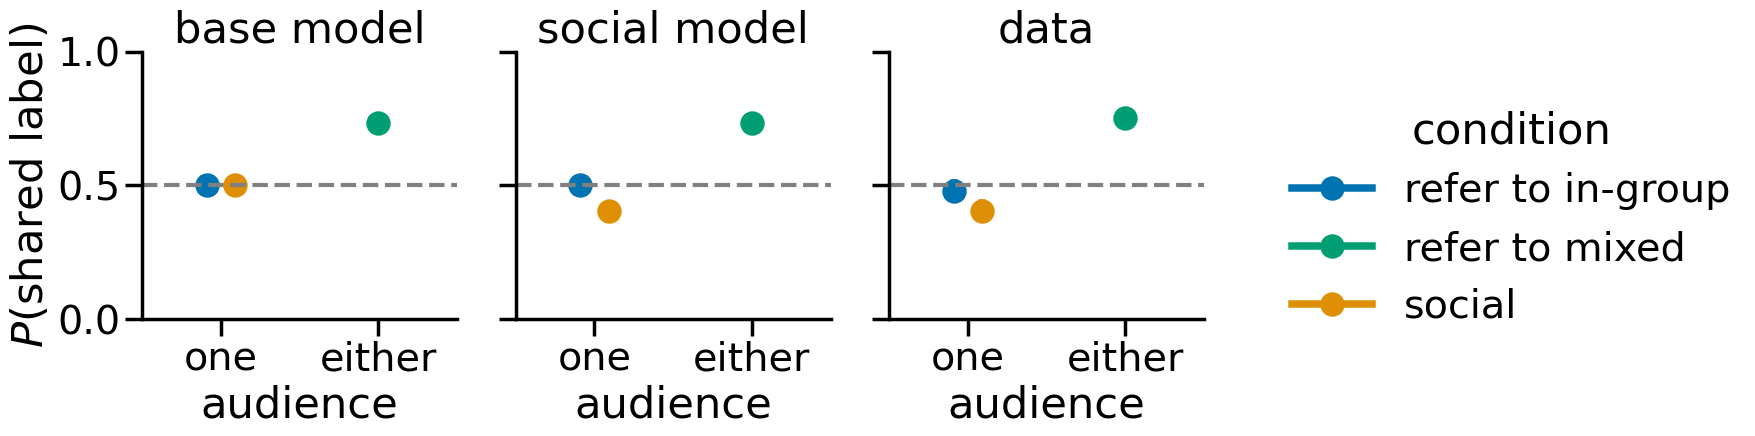

In [20]:
g = sns.FacetGrid(
    preds_df,
    col="model", 
    margin_titles=True,
    height=5.1,
    aspect=0.9
)
g.map_dataframe(
    sns.pointplot,
    x="audience",
    y="p_shared",
    order=["one", "either"],
    hue="condition",
    hue_order=conditions_labels,
    palette=utils.palette,
    dodge=0.18,
    alpha=1
)
g.set_titles(col_template="{col_name}")
g.set(ylim=(0, 1), ylabel="$P(\\text{shared label})$")
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")
g.add_legend(title="condition", bbox_to_anchor=(1.01, 0.5))

plt.savefig(utils.fig_dir + "3pp_red_blue_shared_unique.pdf")
plt.show()

## LR test

In [21]:
from scipy.stats import chi2
lr_stat = 2 * (best_nll_base - best_nll_social)
df = 1
p = 1 - chi2.cdf(lr_stat, df)
print(f"LR test: χ²({df}) = {lr_stat}, p = {p}")

LR test: χ²(1) = 43.244140625, p = 4.831823829931636e-11
